## 1. Plot weekly labels for 2018 and 2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from strategy_implementation import profit_loss_balance, final_balance

df = pd.read_csv("TSLA_weekly_return_volatility.csv")
df_18_19 = df.loc[df["Year"] >= 2018].reset_index()

# import the csv with profit or loss result from week3 homework
trade_18_19 = pd.read_csv("Trade_18_19.csv") 

# add a new column of total weekly return from trade_18_19
# the weekly return can be used as the size of spot
df_18_19["weekly return"] = 0
profit_loss_18_19 = trade_18_19.groupby("Year_Week")["Profit/Loss"].sum().tolist()
df_18_19["weekly return"]= profit_loss_18_19

# Noticed that mean return and volatility are already in percentage
df_18_19.head()

,index,Year,Week_Number,mean_return,volatility,label,weekly return
0,210,2018,0,0.42975,1.832472,green,-1.232338
1,211,2018,1,1.24340,2.890522,green,6.127356
2,212,2018,2,1.01650,1.236940,green,4.305365
3,213,2018,3,-0.40160,1.688542,red,0.000000
4,214,2018,4,0.06780,1.964960,red,0.286655


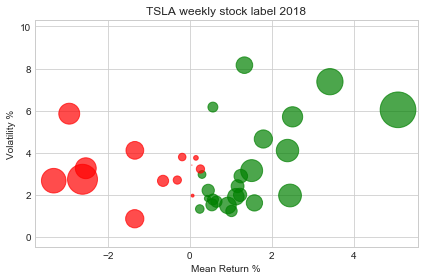

In [2]:
# 2018 plot
plt.style.use("seaborn-whitegrid")
df_18 = df_18_19.loc[(df_18_19["Year"] == 2018)].reset_index()
plt.scatter(df_18["mean_return"], df_18["volatility"], 
            s=30*np.absolute(df_18["weekly return"]), c=df_18["label"],alpha= 0.7 )
plt.title("TSLA weekly stock label 2018")
plt.xlabel("Mean Return %")
plt.ylabel("Volatility %")
plt.tight_layout()
plt.show()

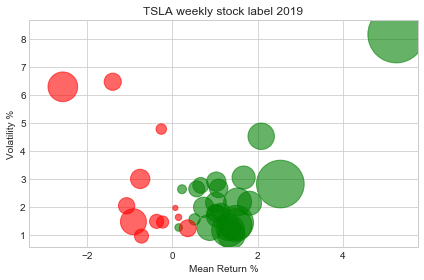

In [3]:
# 2019 plot
df_19 = df_18_19.loc[(df_18_19["Year"] == 2019)].reset_index()
plt.scatter(df_19["mean_return"], df_19["volatility"], 
            s=30*np.absolute(df_19["weekly return"]), c=df_19["label"], alpha= 0.6 )
plt.title("TSLA weekly stock label 2019")
plt.xlabel("Mean Return %")
plt.ylabel("Volatility %")
plt.tight_layout()
plt.show()

#### From the 2 scatter plots above, red week and green week are grouped independently. The size of each spot can reflect the total weekly profit or loss. It usually goes bigger as the average mean return goes bigger. Basically the line separates red and green is on the 0 mean return. Even though some points are slightly over 0 mean, they are red as over 100% volatility. With the comparison of 2018 and 2019, they almost have the same pattern, but the points in 2019 are condesed more tightly. The pattern for both year is that no or just a little return is red condition while above 0 mean return is green condition. Given that I expect nearest-neighbor classifier trained in one year can do well in the other.

## 2. Linear equation strategy

### 2.1 Calculate equation
#### Based on the graph of 2018 above, remove some points that are overlapped with red and green. Then find two points to compute a linear equation. 

In [4]:
# find the two green points close to 0 mean return in the graph
points = df_18_19.loc[(df_18_19["Year"] == 2018) & (df_18_19["label"] == "green") & (df_18_19["mean_return"] >= 0)]
points.sort_values(by=["mean_return"]).head(2)

,index,Year,Week_Number,mean_return,volatility,label,weekly return
44,254,2018,44,0.2428,1.329629,green,2.455244
37,247,2018,37,0.2976,2.969240,green,2.045390


In [5]:
# calculate the equation: y = ax+b
a = (2.9692 - 1.3296) / (0.2976 - 0.2428)
b = 1.3296 - 0.2428 * a
print(f"The line to separate red week and green week is y={a:.2f}x{b:.2f}")

The line to separate red week and green week is y=29.92x-5.93


### 2.2 Apply the linear equation as a new strategy for year 2019
#### If y > 29.92x-5.93, label red; if y <= 29.92x-5.93, label green.

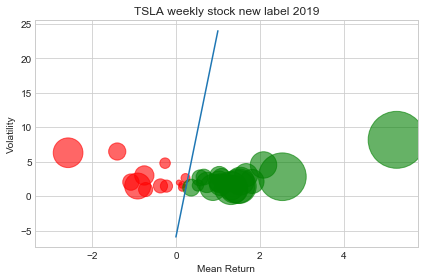

In [6]:
# assign labels for weeks
new_19 = df_18_19.loc[(df_18_19["Year"] == 2019)].reset_index()
new_19.loc[new_19["volatility"] - (29.92 * new_19["mean_return"] - 5.93) > 0 , ["label"]] = "red"
new_19.loc[new_19["volatility"] - (29.92 * new_19["mean_return"] - 5.93) <= 0 , ["label"]] = "green"

# plot the new labels and draw the equation line
fig, ax = plt.subplots()
plt.scatter(new_19["mean_return"], new_19["volatility"], 
            s=30*np.absolute(new_19["weekly return"]), c=new_19["label"], alpha= 0.6 )
x = np.random.randint(2, size=5)
y = 29.92 * x - 5.93
ax.plot(x,y)
plt.title("TSLA weekly stock new label 2019")
plt.xlabel("Mean Return")
plt.ylabel("Volatility")
plt.tight_layout()
plt.show()

In [7]:
# find green weeks
green_weeks = new_19.loc[new_19["label"] == "green", "Week_Number"].tolist()

# apply new labels as strategy
new_trade_19 = trade_18_19.loc[(trade_18_19["Year"] == 2019), ("Week_Number", "Return")].reset_index()
invest = 100

# import stategy implementation function from flie
new_balance_19 = profit_loss_balance(new_trade_19, invest, green_weeks)
new_balance_19

,index,Week_Number,Return,Profit/Loss,Account Balance
0,251,0,-0.068149,0.000000,100.000000
1,252,0,-0.031472,0.000000,100.000000
2,253,0,0.057697,0.000000,100.000000
3,254,1,0.054361,5.436113,105.436113
4,255,1,0.001164,0.122766,105.558879
...,...,...,...,...,...
247,498,51,0.014384,6.415138,452.410916
248,499,51,0.013380,6.053426,458.464341
249,500,51,-0.001299,-0.595765,457.868576
250,501,52,-0.036433,0.000000,457.868576


In [8]:
# figure out the final balance
new_final_balance = final_balance(new_balance_19)
# new_final_balance = new_balance_19.loc[new_balance_19.index[-1], "Account Balance"]
print(f"The final balance of the linear equation strategy is {new_final_balance}")

old_final_balance = final_balance(trade_18_19)
print(f"The final balance of the original manual-label strategy is {old_final_balance}")

The final balance of the linear equation strategy is 457.87
The final balance of the original manual-label strategy is 691.16


#### From the label plotting of 2018, I found two green points close to 0 mean return and calculate a linear equation y=29.92x-5.93. With the implementation of new strategy y=29.92x-5.93, weeks in 2019 were re-labeled and traded with the new label. The final balance of the new strategy is 457.87. It earns money even though it does not earn as much as the original manual-label strategy. 